# Variational Quantum Eigensolver with Estimator Primitive

## Overview

The Variational Quantum Eigensolver (VQE) is an optimization routine for finding the ground state energy (i.e. lowest eigenvalue) of a Hamiltonain and is a considered to be a viable candidate for NISQ hardware. In this tutorial, we will go over how to use IBM Quantum Runtime to submit your VQE's to the cloud. Specifically, we will be looking at calculating the Potential Energy Surface (PES) of the $H_2$ molecule using the estimator primitive. 

### Create Service
First we have to create our service instance and instantiate our estimator factory. In this example we will be working with a simulator for the sake of speed, but by simply changing this one line (for choice of backend) this could run on hardware as well. 

In [45]:
from qiskit_ibm_runtime import IBMRuntimeService, IBMEstimator

service = IBMRuntimeService()
estimator_factory = IBMEstimator(service=service, backend="ibmq_qasm_simulator")

### Molecular Hamiltonians

Now we need to generate the Hamiltonians that we wish to find the ground state energy of. For this task we will be utilizing qiskit nature. First we have to specify how we are converting the fermionic operators of the electronic molecular hamiltonian to qubit operators. Here we will use the Parity Mapper, which maps annihilation to Pauli operators via $ \hat{a} \rightarrow \frac{1}{2} \left ( X_p Z_{p-1} + i Y_p \right ) X_{p+1} ... X_{N} $

In [ ]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

qubit_converter = QubitConverter(ParityMapper(), two_qubit_reduction=True)

For PES we generate the molecular hamiltonians at different bond lengths. At each bond length we will create an electronic structure problem and generate the second quantized (i.e. fermionic) operators. We then compute the true ground state energy to compare against. 

In [81]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms import MinimumEigensolverResult
from qiskit.opflow import TaperedPauliSumOp

total_dist = 4
dist = 0.1
incr_early = 0.1
incr_late = 0.3

real_energies = []
dists = []
ops = []
problems = []
while dist < total_dist:
    molecule = Molecule(geometry=[['H', [0., 0., 0.]], ['H', [0., 0., dist]]])
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', \
                                               driver_type=ElectronicStructureDriverType.PYSCF)

    es_problem = ElectronicStructureProblem(driver)
    second_q_ops = es_problem.second_q_ops()      
    hamiltonian = qubit_converter.convert(second_q_ops[0], num_particles=es_problem.num_particles)
    sol = MinimumEigensolverResult()
    sol.eigenvalue = numpy_solver.compute_minimum_eigenvalue(hamiltonian).eigenvalue
    real_solution = es_problem.interpret(sol).total_energies[0]

    h = hamiltonian.primitive
    h.coeffs = np.real(hamiltonian.coeffs)
    real_energies.append(real_solution)
    ops.append(TaperedPauliSumOp(h, hamiltonian.z2_symmetries))
    dists.append(dist)
    problems.append(es_problem)
    
    if dist > total_dist / 2:
        dist += incr_late
    else:
        dist += incr_early

Now we can use these hamiltonians as the observable list in our estimator factory (thus avoiding the need to create many estimator instances). The VQE routine is formalized as $\min_\theta \langle \Psi | \hat{H} | \Psi \rangle $, so we just need to minimize the expectation values of the hamiltonians. 

In [ ]:
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
import numpy as np

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose()
vqe_energies = []

with estimator_factory(
    circuits=[circuit],
    observables=ops,
) as estimator:
    for i in range(len(ops)):

        def evaluate_expectation(x):
            x = list(x)
            results = estimator(circuit_indices=[0], observable_indices=[i], parameter_values=[x]).values[0]
            return np.real(results)


        initial_point = np.random.uniform(-np.pi, np.pi, 6)
        spsa = SPSA(100)
        _, vqe_solution, _ = spsa.optimize(initial_point.size, evaluate_expectation, initial_point=initial_point) 
        
        sol = MinimumEigensolverResult()
        sol.eigenvalue = vqe_solution
        vqe_sol = es_problem.interpret(sol).total_energies[0]
        vqe_energies.append(vqe_sol)


Now that we solved the electronic hamiltonians, we have to add the nuclear energies.

In [87]:
vqe_interpret = []
for i in range(len(vqe_energies)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = vqe_energies[i]
    sol = problems[i].interpret(sol).total_energies[0]
    vqe_interpret.append(sol)

Finally, we can see our PES curve!

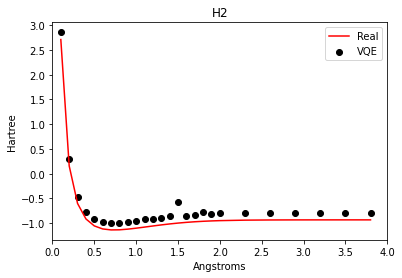

In [94]:
import matplotlib.pyplot as plt

plt.plot(dists, real_energies, label='Real', color='red')
plt.scatter(dists, vqe_interpret, label='VQE', color='black')
plt.title("H2")
plt.xlim(0, 4)
plt.xlabel('Angstroms')
plt.ylabel('Hartree')
plt.legend()
plt.show()

In [96]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.2', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': '0.9.5', 'qiskit': '0.34.2', 'qiskit-nature': '0.3.1', 'qiskit-finance': None, 'qiskit-optimization': '0.3.1', 'qiskit-machine-learning': '0.2.1'}